In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [14]:
IMAGE_FILE = 'sar_1_gray.jpg'

In [16]:
image = cv2.imread(IMAGE_FILE)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, monochrom = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)

In [17]:
with open('sar_1_gray_monochrom.txt', 'w') as file:
    for row in monochrom:
        line = ' '.join(str(pixel) for pixel in row)
        file.write(line + '\n')

In [19]:
print(f"sar_1_gray_monochrom.txt, размер: {monochrom.shape}")

sar_1_gray_monochrom.txt, размер: (400, 600)


In [22]:
plt.figure(figsize=(10, 10))
components = {
    'LL': ll,
    'LH': lh,
    'HL': hl,
    'HH': hh
}

<Figure size 1000x1000 with 0 Axes>

In [20]:
def haar_transform(image):
    image = image.astype(np.float32)
    h, w = image.shape
    temp = np.zeros_like(image)
    
    for i in range(h):
        for j in range(0, w, 2):
            if j + 1 < w:
                temp[i, j // 2] = (image[i, j] + image[i, j + 1]) / 2
                temp[i, j // 2 + w // 2] = (image[i, j] - image[i, j + 1]) / 2
            else:
                temp[i, j // 2] = image[i, j]
    
    result = np.zeros_like(temp)
    
    for j in range(w):
        for i in range(0, h, 2):
            if i + 1 < h:
                result[i // 2, j] = (temp[i, j] + temp[i + 1, j]) / 2
                result[i // 2 + h // 2, j] = (temp[i, j] - temp[i + 1, j]) / 2
            else:
                result[i // 2, j] = temp[i, j]
    
    ll = result[:h // 2, :w // 2]
    lh = result[:h // 2, w // 2:]
    hl = result[h // 2:, :w // 2]
    hh = result[h // 2:, w // 2:]
    
    return ll, lh, hl, hh, result

In [21]:
ll, lh, hl, hh, haar_result = haar_transform(image_gray)

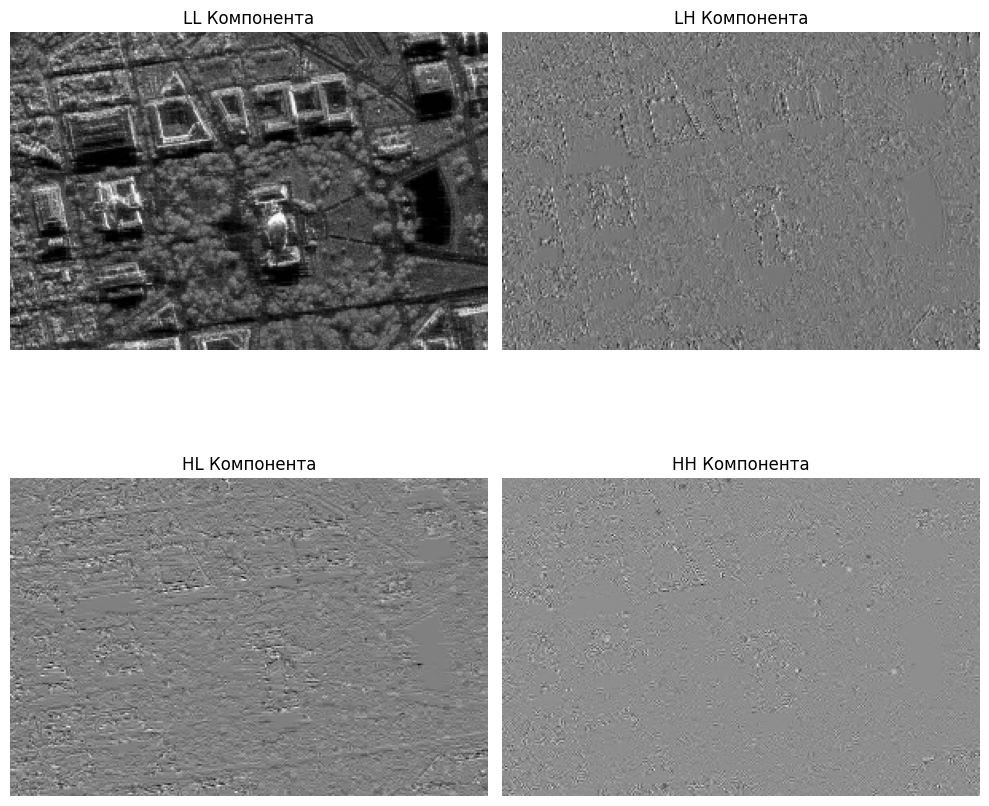

In [23]:
plt.figure(figsize=(10, 10))
components = {
    'LL': ll,
    'LH': lh,
    'HL': hl,
    'HH': hh
}
for i, (name, comp) in enumerate(components.items(), 1):
    plt.subplot(2, 2, i)
    plt.imshow(comp, cmap='gray')
    plt.title(f'{name} Компонента')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
def quantize(coeffs, n_quants):
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    step = (max_val - min_val) / n_quants if max_val != min_val else 1
    quantized = np.round((coeffs - min_val) / step).astype(int)
    return quantized, min_val, step

In [25]:
def dequantize(quantized, min_val, step):
    return min_val + quantized * step

In [26]:
num_quants = 4

In [27]:
lh_q, lh_min, lh_step = quantize(lh, num_quants)
hl_q, hl_min, hl_step = quantize(hl, num_quants)
hh_q, hh_min, hh_step = quantize(hh, num_quants)

In [28]:
lh_restored = dequantize(lh_q, lh_min, lh_step)
hl_restored = dequantize(hl_q, hl_min, hl_step)
hh_restored = dequantize(hh_q, hh_min, hh_step)

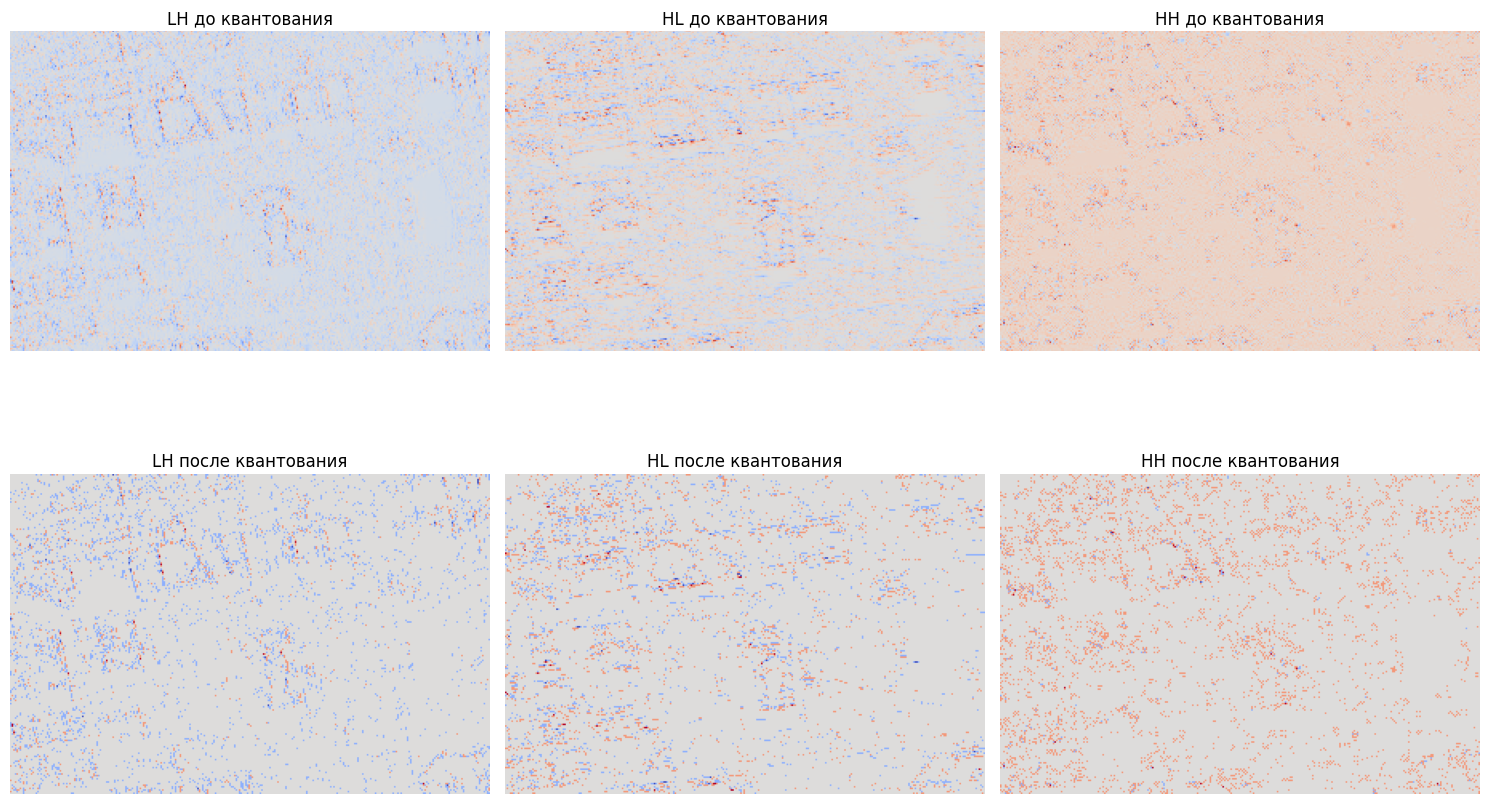

In [30]:
plt.figure(figsize=(15, 10))
before = {'LH': lh, 'HL': hl, 'HH': hh}
after = {'LH': lh_restored, 'HL': hl_restored, 'HH': hh_restored}

for i, (name, comp) in enumerate(before.items(), 1):
    plt.subplot(2, 3, i)
    plt.imshow(comp, cmap='coolwarm')
    plt.title(f'{name} до квантования')
    plt.axis('off')

for i, (name, comp) in enumerate(after.items(), 1):
    plt.subplot(2, 3, i + 3)
    plt.imshow(comp, cmap='coolwarm')
    plt.title(f'{name} после квантования')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
def run_length_encode(data):
    flat = data.flatten()
    encoded = []
    count = 1
    for i in range(1, len(flat)):
        if flat[i] == flat[i - 1]:
            count += 1
        else:
            encoded.append((flat[i - 1], count))
            count = 1
    encoded.append((flat[-1], count))
    return encoded

In [32]:
lh_rle = run_length_encode(lh_q)
hl_rle = run_length_encode(hl_q)
hh_rle = run_length_encode(hh_q)

In [33]:
with open('sar_1_gray_haar.txt', 'w') as file:
    np.savetxt(file, ll, fmt='%d')
    file.write('\n')
    
    components_rle = [('LH', lh_rle), ('HL', hl_rle), ('HH', hh_rle)]
    for name, data in components_rle:
        file.write(f'=== {name} ===\n')
        for value, count in data:
            file.write(f'{value} {count}\n')
        file.write('\n')

print("Компоненты сохранены в файл 'sar_1_gray_haar.txt'")

Компоненты сохранены в файл 'sar_1_gray_haar.txt'


In [37]:
with open('sar_1_gray_monochrom.txt', 'r') as f:
    original_size = len(f.read().encode('utf-8'))

with open('sar_1_gray_haar.txt', 'r') as f:
    compressed_size = len(f.read().encode('utf-8'))

print(f'\nИзначальный размер изображения: {original_size} байт')
print(f'После сжатия: {compressed_size} байт')
print(f'Сжали в: {original_size / compressed_size:.2f} раз')


Изначальный размер изображения: 528542 байт
После сжатия: 290132 байт
Сжали в: 1.82 раз
